# SHAP

In [1]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
#downgrade sklearn to version compatible with pickle
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.0.2

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 26.5 MB 4.7 MB/s eta 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.4.10 requires scikit-learn>=1.3.2, but you have scikit-learn 1.0.2 which is incompatible.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [3]:
import pickle

# Load Lung Cancer dataframe from file using pickle

with open('/workspace/home/nlst_sybil_training_df.pkl', 'rb') as file:
    nlst_sybil_training_df = pickle.load(file)

In [52]:
import pickle

# Load Lung Cancer dataframe from file using pickle

with open('/workspace/home/ucla_sybil_training_df2.pkl', 'rb') as file:
    ucla_sybil_training_df = pickle.load(file)

In [5]:
import pickle

# Load Lung Cancer dataframe from file using pickle

with open('/workspace/home/best_xgboost_plco_im.pkl', 'rb') as file:
    best_xgboost_plco_im = pickle.load(file)

In [24]:
import shap
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

In [53]:
# Flatten the nested lists
flattened_data_nlst = nlst_sybil_training_df['Feature Vector'].apply(lambda x: x[0])

# Convert the flattened data into a DataFrame with separate columns
flat_feature_vector_nlst_df = pd.DataFrame(flattened_data_nlst.tolist(), index=nlst_sybil_training_df.index)

In [54]:
# Flatten the nested lists
flattened_data = ucla_sybil_training_df['Feature Vector'].apply(lambda x: x[0])

# Convert the flattened data into a DataFrame with separate columns
flat_feature_vector_df = pd.DataFrame(flattened_data.tolist(), index=ucla_sybil_training_df.index)

flat_feature_vector_df = flat_feature_vector_df.reset_index(drop=True)

In [55]:
plco_training_features_list = ['age_at_last_screening', 'education', 'BMI', 'diagcopd', 'race', 'cancer_history', 'family_cancer_history',
                               'cigsmok', 'smokeday', 'smokeyr', 'years_since_quiting_smoking']
plco_label = ['first_year_diagnosis']

In [182]:
def perform_data_preprocessing_im(X_nlst):
    # Define the numerical and categorical features
    numerical_cols = X_nlst[plco_training_features_list].select_dtypes(include=['number']).columns  
    categorical_cols = X_nlst[plco_training_features_list].select_dtypes(exclude=['number']).columns  
    pca_cols = [str(col) for col in flat_feature_vector_nlst_df.columns]

    # Impute and scale numerical columns
    numerical_data = X_nlst[numerical_cols]

    # Impute missing values
    num_imputer = SimpleImputer(strategy='mean')
    numerical_data_imputed = num_imputer.fit_transform(numerical_data)

    # Scale numerical data
    num_scaler = MinMaxScaler()
    numerical_data_scaled = num_scaler.fit_transform(numerical_data_imputed)

    # Impute and one-hot encode categorical columns
    categorical_data = X_nlst[categorical_cols]

    # Impute missing values
    cat_imputer = SimpleImputer(strategy='most_frequent')
    categorical_data_imputed = cat_imputer.fit_transform(categorical_data)

    # One-hot encode categorical data
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    categorical_data_encoded = encoder.fit_transform(categorical_data_imputed)

    # Scale and apply PCA to image feature columns
    image_data = X_nlst[pca_cols]

    # Scale image data
    img_scaler = MinMaxScaler()
    image_data_scaled = img_scaler.fit_transform(image_data)

    # Apply PCA
    pca = PCA(n_components=0.95)
    image_data_pca = pca.fit_transform(image_data_scaled)

    # Combine all preprocessed features
    preprocessed_data = np.hstack((numerical_data_scaled, categorical_data_encoded, image_data_pca))

    # Create a DataFrame with preprocessed data
    all_feature_names = list(numerical_cols) + encoder.get_feature_names_out(categorical_cols).tolist() + [f'PC{i+1}' for i in range(image_data_pca.shape[1])]
    preprocessed_df = pd.DataFrame(preprocessed_data, columns=all_feature_names)

    # Show the first few rows of the preprocessed DataFrame
    #print(preprocessed_df.head())
    return preprocessed_df

In [126]:
X_nlst = nlst_sybil_training_df[plco_training_features_list] 
X_nlst = pd.concat([X_nlst, flat_feature_vector_nlst_df], axis=1)
X_nlst.columns = [str(col) for col in X_nlst.columns]

y_nlst = nlst_sybil_training_df['first_year_diagnosis']

X_ucla = ucla_sybil_training_df[plco_training_features_list]
X_ucla = pd.concat([X_ucla, flat_feature_vector_df], axis=1)
X_ucla.columns = [str(col) for col in X_ucla.columns]

y_ucla = ucla_sybil_training_df['first_year_diagnosis']

In [183]:
X_nlst_processed = perform_data_preprocessing_im(X_nlst)
X_ucla_processed = perform_data_preprocessing_im(X_ucla)

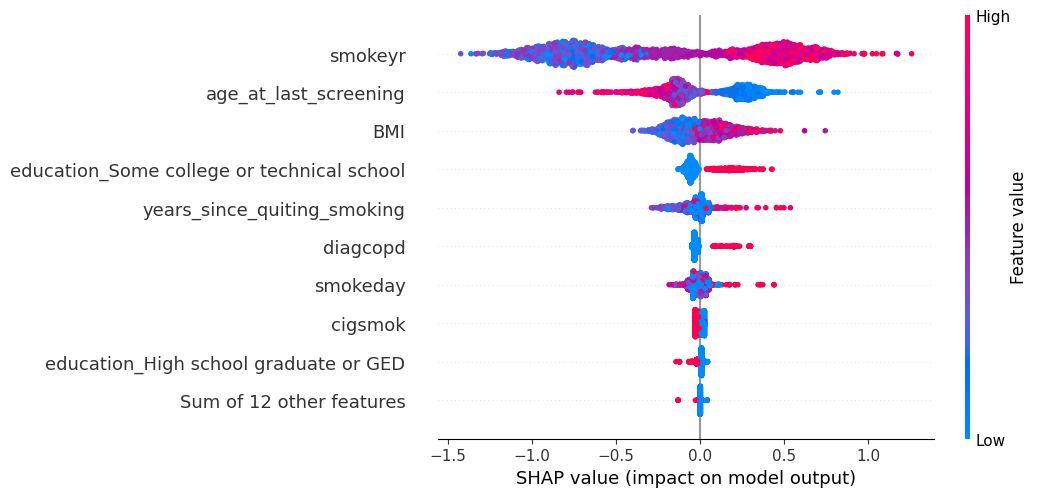

In [184]:
all_feature_names = X_nlst_processed.columns.tolist()

# Select specific features to plot
selected_features = X_nlst_processed.columns.tolist()[0:21]
#plco_training_features_list

# Find indices of selected features
selected_indices = [i for i, feature in enumerate(all_feature_names) if feature in selected_features]

# Filter SHAP values and feature names
filtered_shap_values = shap_values.values[:, selected_indices]
filtered_feature_names = [all_feature_names[i] for i in selected_indices]

# Filter the original data to match the selected features
filtered_data = X_nlst_processed[selected_features]

# Create a new SHAP explanation object for selected features
filtered_shap_explanation = shap.Explanation(filtered_shap_values, base_values=shap_values.base_values, data=filtered_data, feature_names=filtered_feature_names)

# Plot the beeswarm plot for selected features
shap.initjs()
shap.plots.beeswarm(filtered_shap_explanation)

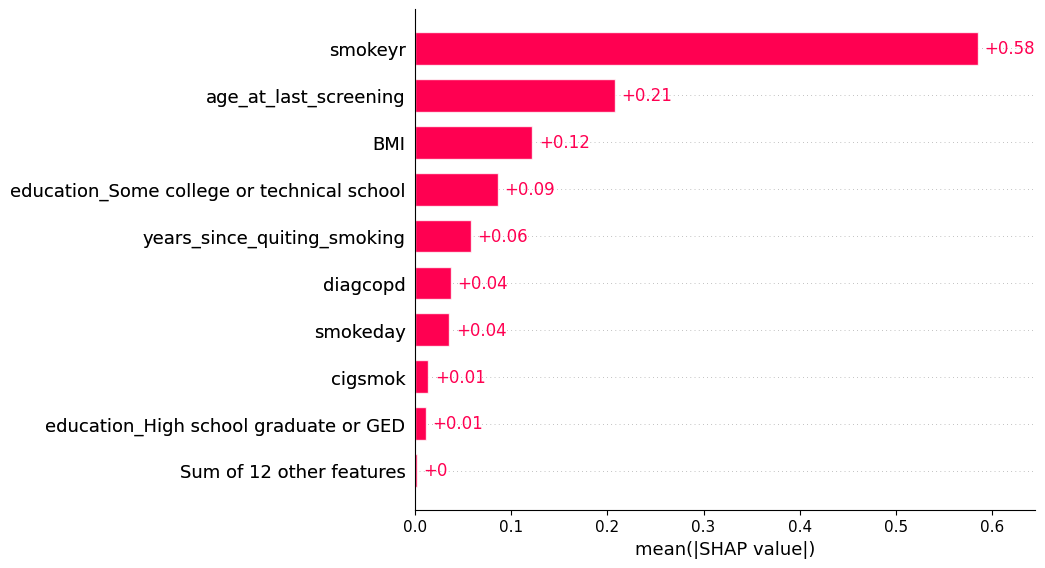

In [187]:
shap.plots.bar(filtered_shap_explanation)

In [185]:
instance_index = 0  # Index of the instance you want to plot
#shap.force_plot(explainer.expected_value, shap_values[instance_index], X_ucla_prepared[instance_index], feature_names=plco_training_features_list)
shap.force_plot(filtered_shap_explanation[instance_index])

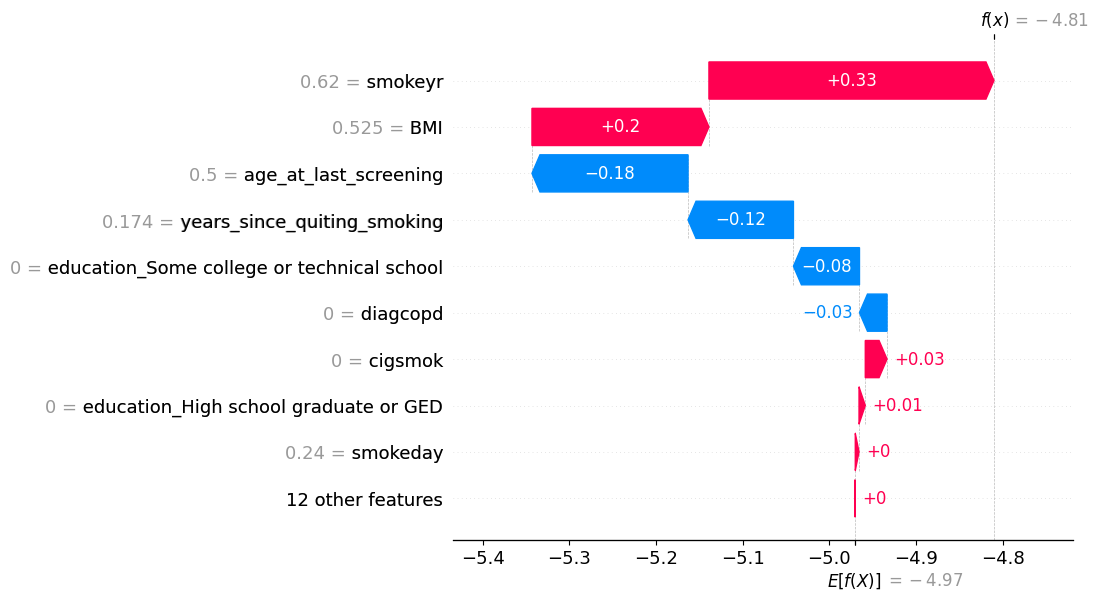

In [186]:
# visualize the first prediction's explanation
shap.plots.waterfall(filtered_shap_explanation[0])

In [143]:
# Explain the model's predictions using SHAP values
explainer = shap.Explainer(best_xgboost_plco_im.best_estimator_['xgb'], X_nlst_processed)
shap_values = explainer(X_nlst_processed)

# Plot SHAP values for the first instance in the test set
shap.initjs()
#shap.force_plot(explainer.expected_value, shap_values, X_nlst_prepared, feature_names=plco_training_features_list)

instance_index = 0  # Index of the instance you want to plot
#shap.force_plot(explainer.expected_value, shap_values[instance_index], X_ucla_prepared[instance_index], feature_names=plco_training_features_list)
shap.force_plot(shap_values[instance_index])

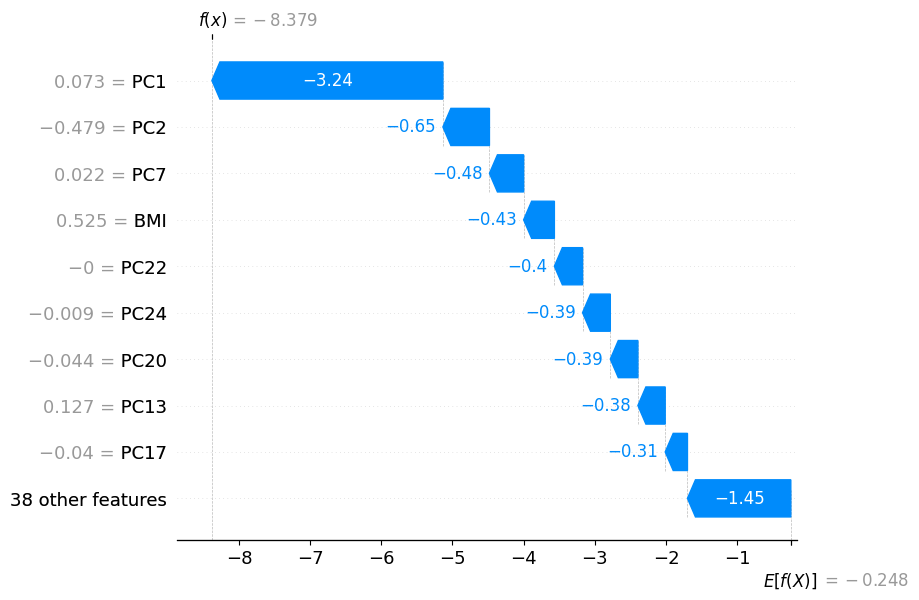

In [144]:
# train an XGBoost model

model = best_xgboost_plco_im.best_estimator_['xgb'].fit(X_nlst_processed, y_nlst)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_nlst_processed)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [78]:
X_nlst = nlst_sybil_training_df[plco_training_features_list] 
y_nlst = nlst_sybil_training_df['first_year_diagnosis']

X_ucla = ucla_sybil_training_df[plco_training_features_list]
y_ucla = ucla_sybil_training_df['first_year_diagnosis']

In [79]:
# Define the numerical and categorical features
numerical_cols = X_nlst[plco_training_features_list].select_dtypes(include=['number']).columns  
categorical_cols = X_nlst[plco_training_features_list].select_dtypes(exclude=['number']).columns  


# Define the pipeline for PCA on numerical features and imputation for missing values
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', KNNImputer(n_neighbors=5)),
            ('scaler', MinMaxScaler())
        ]), numerical_cols),  # Apply imputer and scaler to  numerical features
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)  # Apply imputer and one-hot-encoding to categorical features
    ]
)

def perform_data_preprocessing(df, feature_list):
    training_df = df[feature_list]

    #deal with null values
    
    #get columns with numerical values
    numerical_cols = training_df.select_dtypes(include=['number']).columns
    
    # Replace null values with mean of each numerical column
    training_df[numerical_cols] = training_df[numerical_cols].fillna(training_df[numerical_cols].mean())
    
    #get columns with categorical values
    categorical_cols = training_df.select_dtypes(exclude=['number']).columns
    
    # Replace null values with mode of each categorical column
    training_df[categorical_cols] = training_df[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))
    
    #perform one-hot encoding on categorical data
    training_df = pd.get_dummies(training_df, columns=categorical_cols)
    
    #cast boolean values to 1/0
    training_df = training_df.astype(int)
    
    return training_df

X_nlst_prepared = perform_data_preprocessing(X_nlst, plco_training_features_list)
X_ucla_prepared = perform_data_preprocessing(X_ucla, plco_training_features_list)

X_nlst_prepared = preprocessor.fit_transform(X_nlst)
X_ucla_prepared = preprocessor.transform(X_ucla)

X_nlst_prepared

In [189]:
# Select specific features to plot
selected_features = X_nlst_processed.columns.tolist()[0:21]

In [193]:
filtered_shap_values = shap_values[:,selected_features]

[12:25:14] WARNING: /opt/rapids/src/xgboost/src/learner.cc:767: 
Parameters: { "weight_class" } are not used.



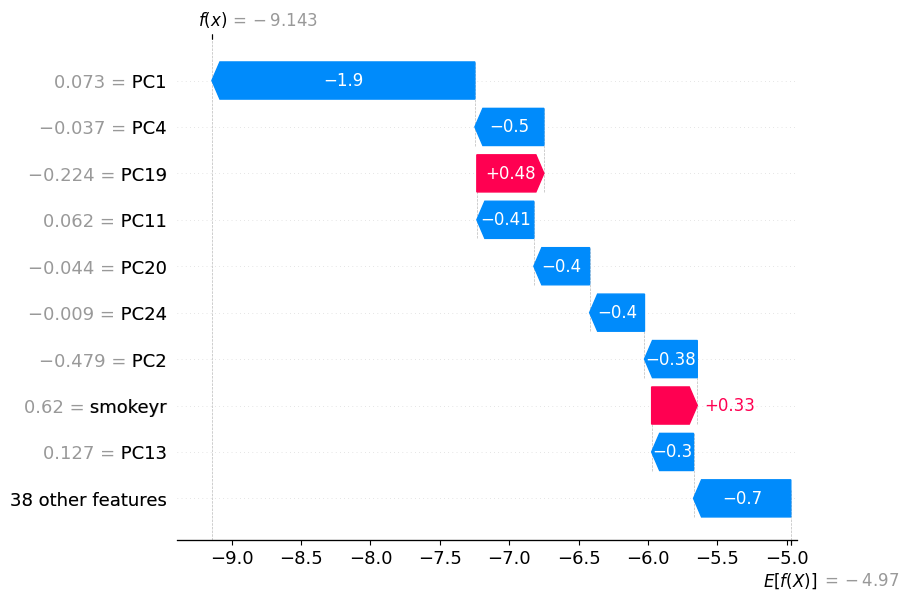

In [145]:
model = XGBClassifier(weight_class = 'balanced').fit(X_nlst_processed, y_nlst)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_nlst_processed)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

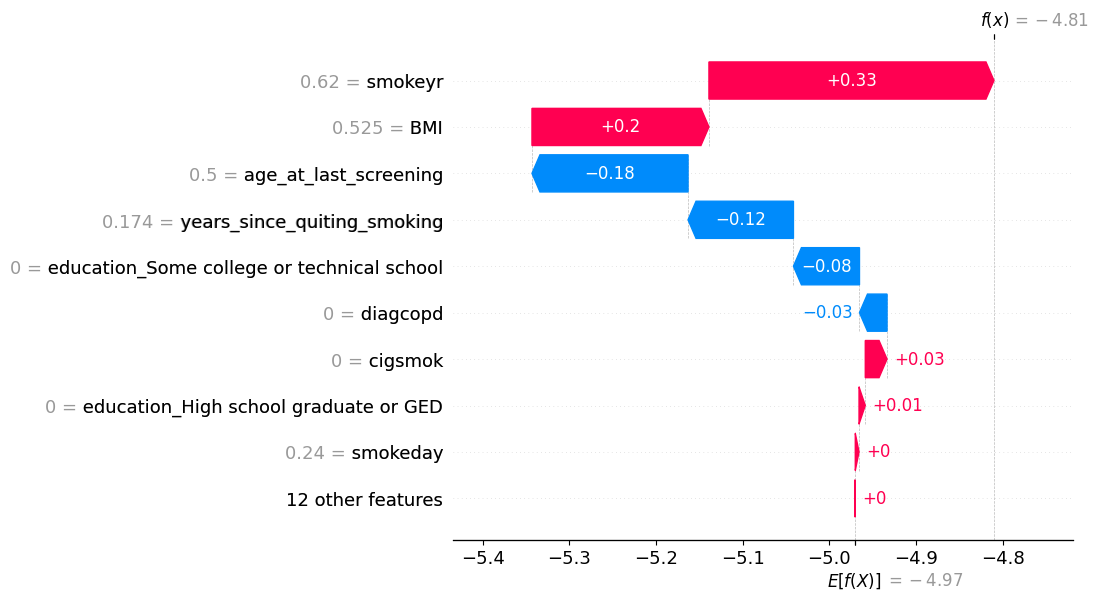

In [194]:
shap.plots.waterfall(filtered_shap_values[0])

In [146]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])

In [195]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(filtered_shap_values[0])

In [147]:
# visualize all the training set predictions
shap.plots.force(shap_values[:500])

In [196]:
# visualize all the training set predictions
shap.plots.force(filtered_shap_values[:500])

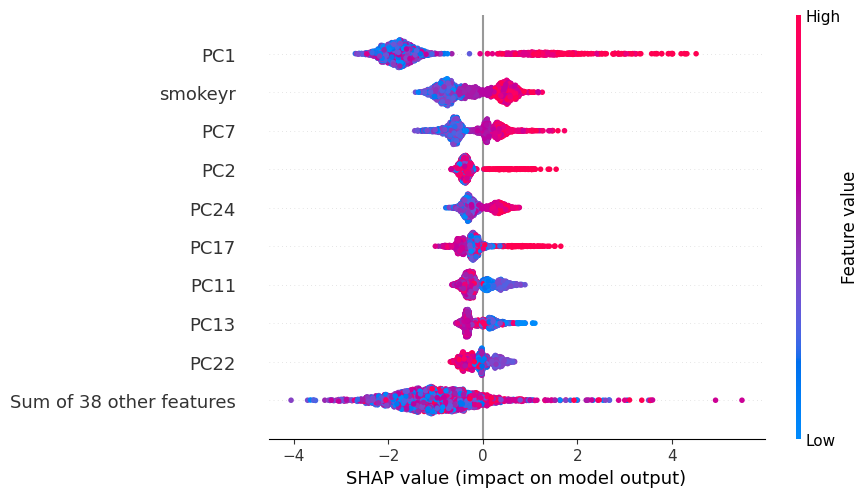

In [148]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

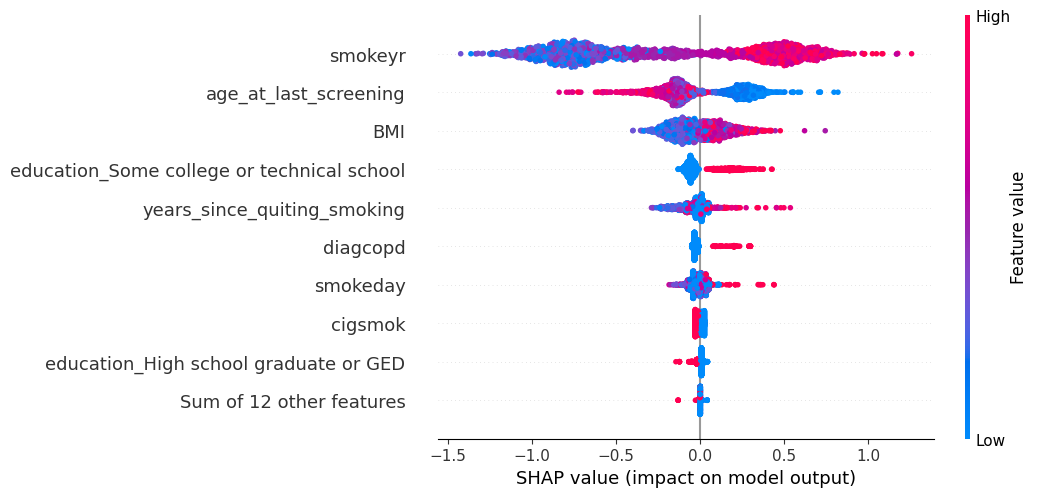

In [197]:
# summarize the effects of all the features
shap.plots.beeswarm(filtered_shap_values)

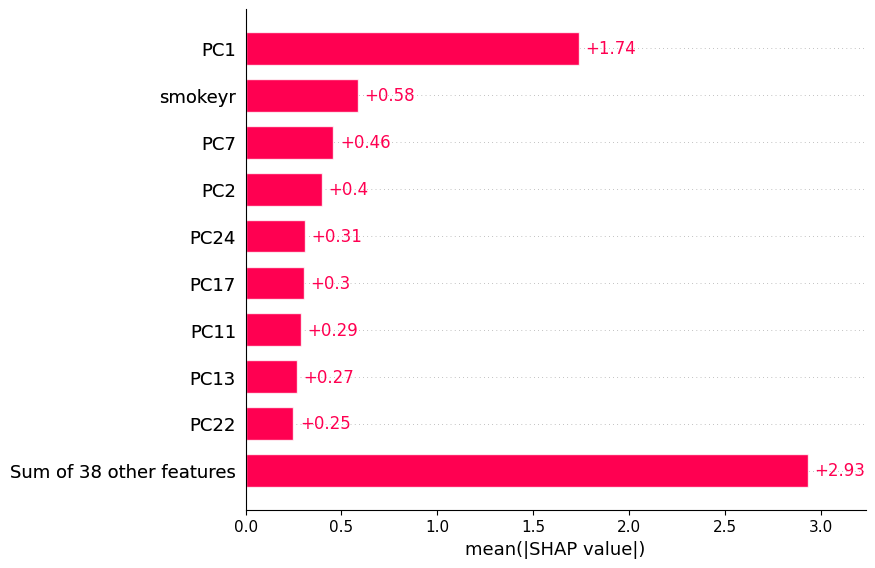

In [150]:
shap.plots.bar(shap_values)

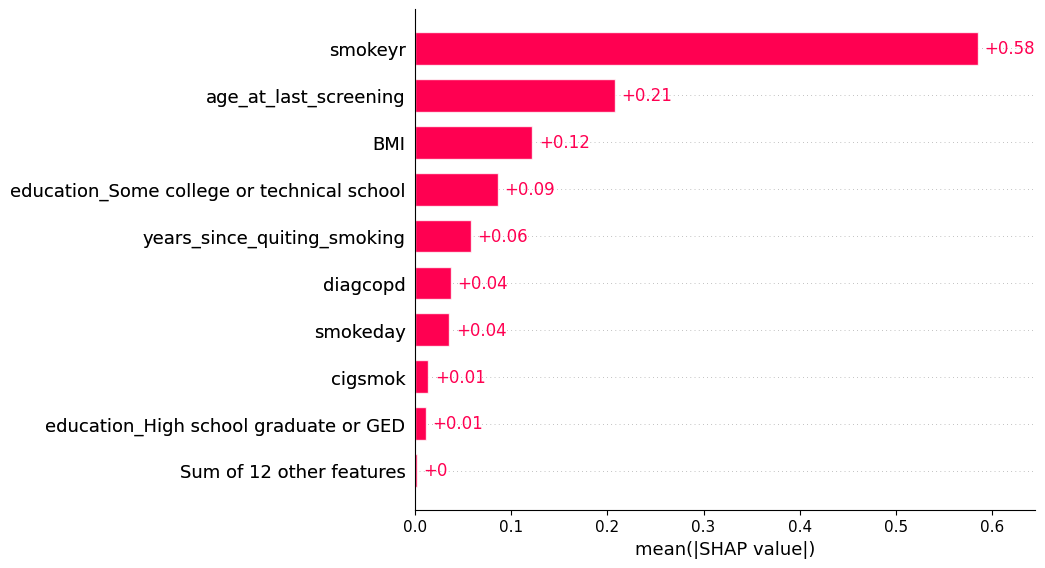

In [198]:
shap.plots.bar(filtered_shap_values)